In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from SimPEG import Mesh
from SimPEG import Utils
from SimPEG import Maps
from SimPEG import Regularization
from SimPEG import DataMisfit
from SimPEG import Optimization
from SimPEG import InvProblem
from SimPEG import Directives
from SimPEG import Inversion
from SimPEG import PF




In [2]:
workDir = 'C:\\Users\\DominiqueFournier\\Desktop\\Workspace\\Paolo'
outDir = "SimPEG_GRAV_Homo_Inv\\"
dsep = '\\'



In [9]:
# Load data, mesh and topography files
mesh = Mesh.TensorMesh.readUBC(workDir + dsep +  "meshWide.msh")
survey = Utils.io_utils.readUBCgravityObservations(workDir + dsep + "Obs_FLT5km.grv")
topo = np.genfromtxt(
    workDir + dsep + "topography.txt", skip_header=1
)

# Read the geological model
geoModel = mesh.readModelUBC(workDir + dsep + "BasementModel.den")

# Convert the unit to relative density
m0 = geoModel.copy()
m0[m0==1] = 0.2


<IPython.core.display.Javascript object>


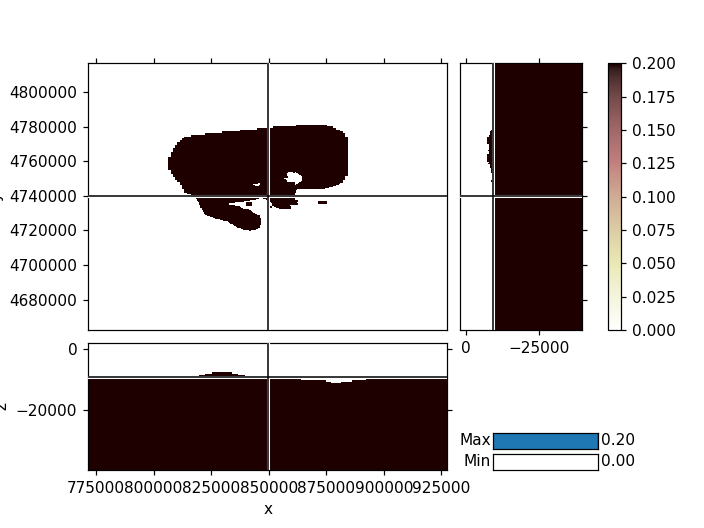

In [4]:
mesh.plot_3d_slicer(m0, transparent='slider', pcolorOpts={'cmap':'pink_r'})


<IPython.core.display.Javascript object>


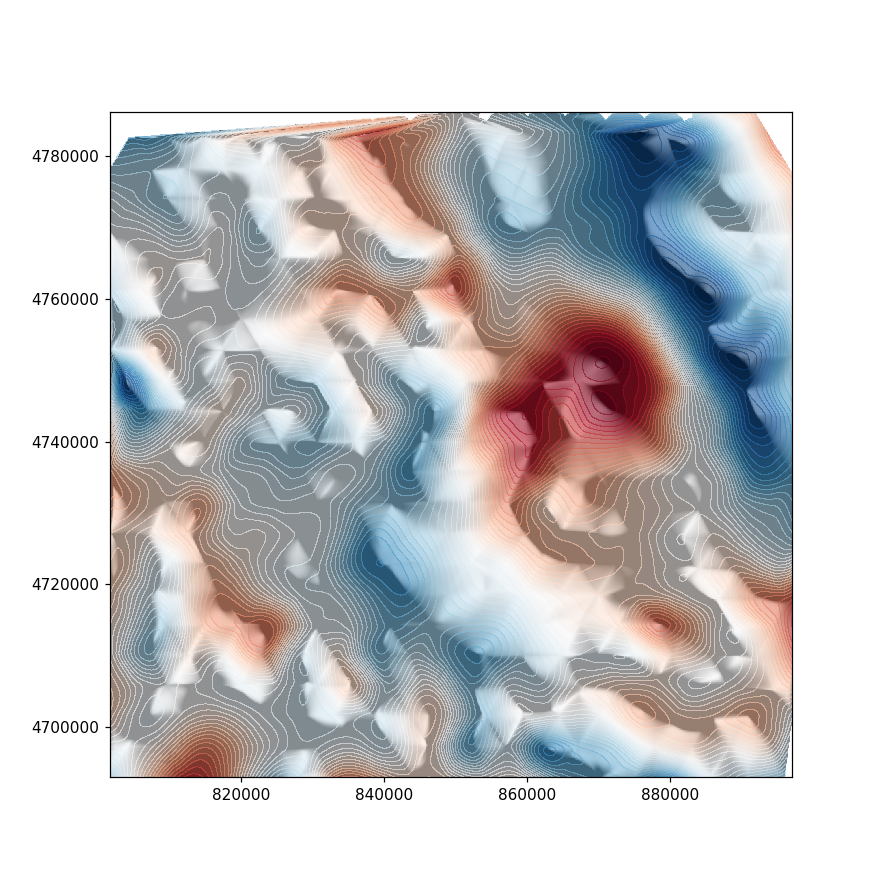

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


In [5]:
#We can plot the data, looks like this,
xyLocs = survey.srcField.rxList[0].locs
fig = plt.figure(figsize=(8,8))
axs = plt.subplot()
im,CS = Utils.PlotUtils.plotDataHillside(
    xyLocs[:,0], xyLocs[:,1], survey.dobs, distMax=3500,
    axs=axs, alpha=0.6,  alphaHS=1., altdeg=15,
    ve=100)

In [6]:
# Find the active cells (below topo)
actv = Utils.surface2ind_topo(mesh, topo, 'N')


In [7]:
survey.nD

410

In [10]:

# Choice for the homogeneous model
useMrefValues = True

# Get unique geo units
geoUnits = np.unique(geoModel).tolist()

# Compute an a median value for each homogeneous units
mUnit = np.asarray([np.median(m0[geoModel==unit]) for unit in geoUnits])

# Apply choice
if useMrefValues:
    mref = np.r_[mUnit, m0[actv]*0] 
    mstart = np.r_[mUnit,m0[actv]]
else:
    mref = np.r_[mUnit*0, m0[actv]*0]
    mstart = np.r_[mUnit*0, m0[actv]]

#actv = mrho!=-100

# Build list of indecies for the geounits
index = []
for unit in geoUnits:
#    if unit!=0:
    index += [(geoModel==unit)[actv]]
nC = len(index)

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Creat reduced identity map
homogMap = Maps.SurjectUnits(index)
homogMap.P

# Create a wire map for a second model space
wires = Maps.Wires(('homo', nC), ('hetero', int(actv.sum())))

# Create Sum map
sumMap = Maps.SumMap([homogMap*wires.homo, wires.hetero])


#%% Run inversion
prob = PF.Gravity.GravityIntegral(
    mesh, rhoMap=sumMap, actInd=actv,
    parallelized=True, Jpath = workDir + "\\sensitivity.zarr")

survey.pair(prob)
 


In [23]:
actv.sum(),sumMap.shape, gtgdiag.shape, scale.shape

(1279054, (1279054, 1279056), (1279056,), (1279058, 1279058))

In [26]:
# Make depth weighting
wr = np.zeros_like(mstart)

# Take the cell number out of the scaling.
# Want to keep high sens for large volumnes    
scale = Utils.sdiag(np.r_[Utils.mkvc(1./homogMap.P.sum(axis=0)),np.ones(int(actv.sum()))])

gtgdiag = prob.getJtJdiag(mstart)
# for ii in range(survey.nD):
#     wr += ((prob.G[ii, :]*prob.rhoMap.deriv(mstart)*scale)/survey.std[ii])**2.

wr = Utils.mkvc(np.sum((Utils.sdiag(Utils.mkvc(gtgdiag)**0.5) * scale).power(2.), axis=0))
# Scale the model spaces independently
wr[wires.homo.index] /= (np.max((wires.homo*wr)))
wr[wires.hetero.index] /= (np.max(wires.hetero*wr))
wr = wr**0.5



Mesh.TensorMesh.writeModelUBC(mesh, workDir + dsep + outDir + 'SensWeights.den',
                              actvMap*(wires.hetero*wr))


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\DominiqueFournier\\Desktop\\Workspace\\Paolo\\SimPEG_GRAV_Homo_Inv\\SensWeights.den'

In [ ]:
## Create a regularization
# For the homogeneous model
regMesh = Mesh.TensorMesh([nC])

reg_m1 = Regularization.Sparse(regMesh, mapping=wires.homo)
reg_m1.cell_weights = wires.homo*wr*2.
reg_m1.norms = np.c_[2, 2, 2, 2]
reg_m1.mref = mref

# Regularization for the voxel model
reg_m2 = Regularization.Sparse(mesh, indActive=actv, mapping=wires.hetero)
reg_m2.cell_weights = wires.hetero*wr
reg_m2.norms = np.c_[2, 2, 2, 2]
reg_m2.mref =  mref

reg = reg_m1 + reg_m2

dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

opt = Optimization.ProjectedGNCG(maxIter=30, lower=-.3,
                                 upper=0.3, 
                                 maxIterLS = 20, maxIterCG= 30, 
                                 tolCG = 1e-4)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 1.)
IRLS = Directives.Update_IRLS(f_min_change=1e-4, minGNiter=2)
update_Jacobi = Directives.UpdatePreconditioner()
#saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap*sumMap)
#saveModel.fileName = work_dir + dsep + out_dir + 'GRAV'

saveDict = Directives.SaveOutputDictEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[betaest, IRLS, saveDict,
                                                      update_Jacobi])
# Run inversion
mrec = inv.run(mstart)

# Plot predicted
pred = prob.fields(mrec)



SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2018-12-08-18-37.npz'
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.52e+05  5.65e+07  7.77e+01  7.61e+07    4.77e+02      0              
Start CG solve
CG solve time: 1026.8288366794586
   1  1.26e+05  6.32e+03  1.73e-02  8.49e+03    2.57e+02      0              
Start CG solve
CG solve time: 1007.3719553947449
   2  6.30e+04  5.72e+03  2.08e-02  7.03e+03    2.52e+02      0   Skip BFGS  
Start CG solve


In [1]:
# PF.Gravity.plot_obs_2D(survey, 'Observed Data')
print("Final misfit:" + str(np.sum(((survey.dobs-pred)/survey.std)**2.)))

#%% Write result
if getattr(invProb, 'l2model', None) is not None:

    m_l2 = actvMap*(sumMap*invProb.l2model)
    Mesh.TensorMesh.writeModelUBC(mesh, work_dir + dsep + out_dir + 'Total_inv_l2l2.den', m_l2)

    m_l2 = actvMap*(homogMap*wires.homo*invProb.l2model)
    Mesh.TensorMesh.writeModelUBC(mesh, work_dir + dsep + out_dir + 'Homoge_inv_l2l2.den', m_l2)

    m_l2 = actvMap*(wires.hetero*invProb.l2model)
    Mesh.TensorMesh.writeModelUBC(mesh, work_dir + dsep + out_dir + 'Hetero_inv_l2l2.den', m_l2)
    
    PF.Gravity.writeUBCobs(work_dir + out_dir + dsep + 'Predicted_l2.pre',
                         survey, d=survey.dpred(invProb.l2model))

m_lp = actvMap*(sumMap*invProb.model)
Mesh.TensorMesh.writeModelUBC(mesh, work_dir + dsep + out_dir + 'Total_inv_lp.den', m_lp)

m_lp = actvMap*(homogMap*wires.homo*invProb.model)
Mesh.TensorMesh.writeModelUBC(mesh, work_dir + dsep + out_dir + 'Homoge_inv_lp.den', m_lp)

m_lp = actvMap*(wires.hetero*invProb.model)
Mesh.TensorMesh.writeModelUBC(mesh, work_dir + dsep + out_dir + 'Hetero_inv_lp.den', m_lp)

PF.Gravity.writeUBCobs(work_dir + out_dir + dsep + 'Predicted_lp.pre',
                         survey, d=invProb.dpred)

NameError: name 'np' is not defined